# Импорт библиотек и загрузка данных

Отдельно установим библиотеку rdkit

In [1]:
%pip install rdkit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 45.1 MB/s eta 0:00:00


In [3]:
%pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.1 MB/s eta 0:00:00


In [58]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

ModuleNotFoundError: No module named 'torch'

Ввведем константные значения

In [5]:
RANDOM_STATE = 12345
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


Выгрузим имеющиеся данные

In [56]:
df_1400 = pd.read_excel("./1400.xlsx")

# Немного аналитики

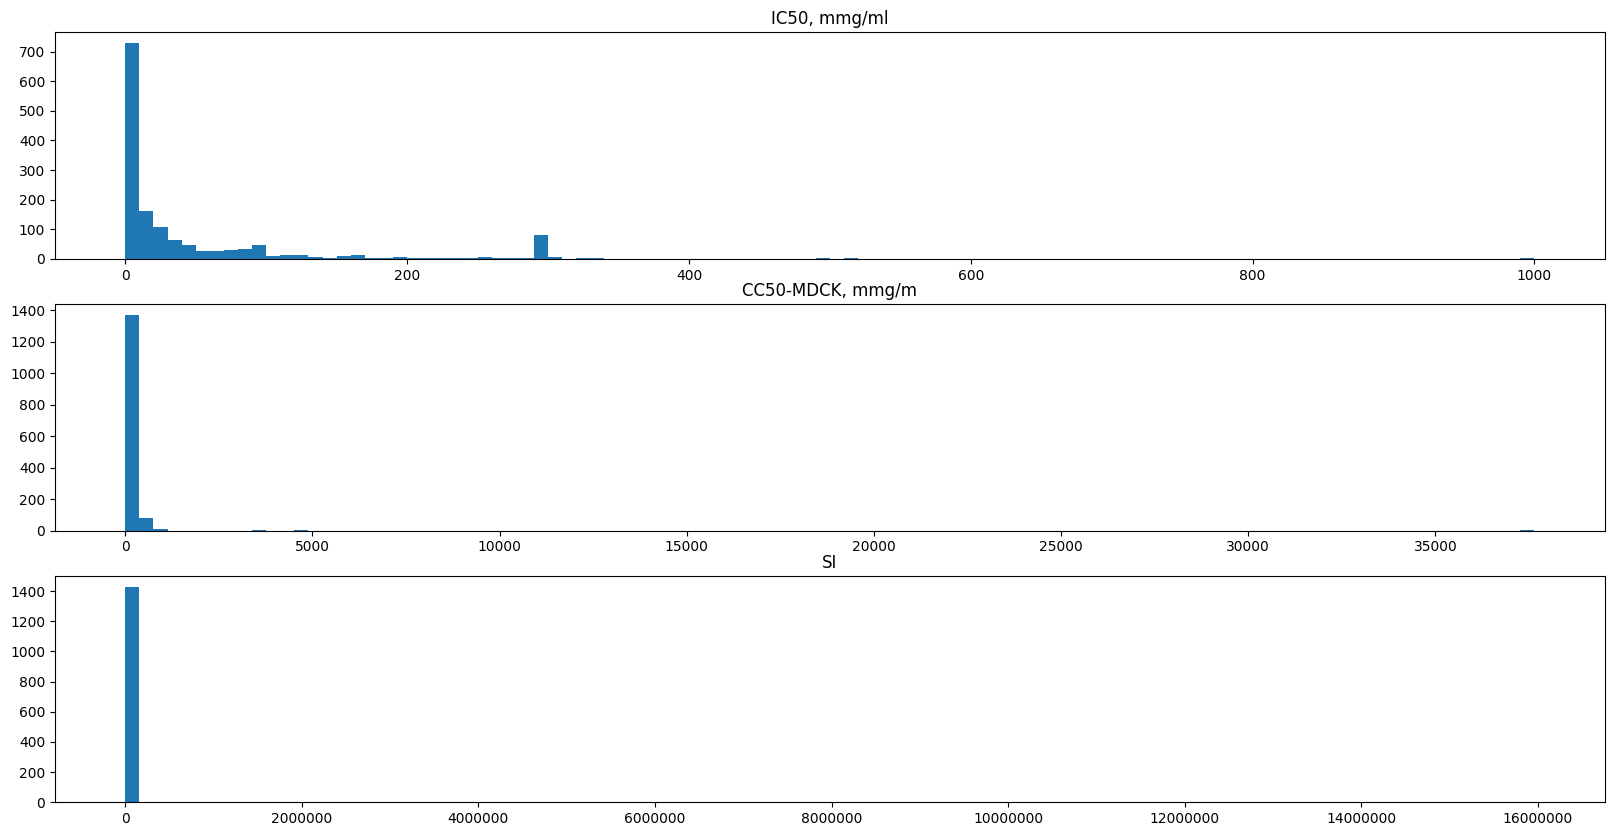

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,10))
#ax1.title("IC50, mmg/ml")
ax1.hist(x=df_1400["IC50, mmg/ml"], bins=100)
ax1.set_title("IC50, mmg/ml")
ax2.set_title("CC50-MDCK, mmg/m")
ax2.hist(x=df_1400["CC50-MDCK, mmg/ml"], bins=100)
ax3.set_title("SI")
ax3.hist(x=df_1400["SI"], bins=100)
plt.ticklabel_format(style = 'plain')

Как мы видим, данные распределены не нормально, с явно выраженной правосторонняя асимметрия. Некоторые графики представляют из себя один сплошной выброс.
Преобразуем данные

In [10]:
df_1400 = df_1400[df_1400["IC50, mmg/ml"] < 200]
df_1400 = df_1400[df_1400["CC50-MDCK, mmg/ml"] < 200]
df_1400 = df_1400[df_1400["SI"] < 130]

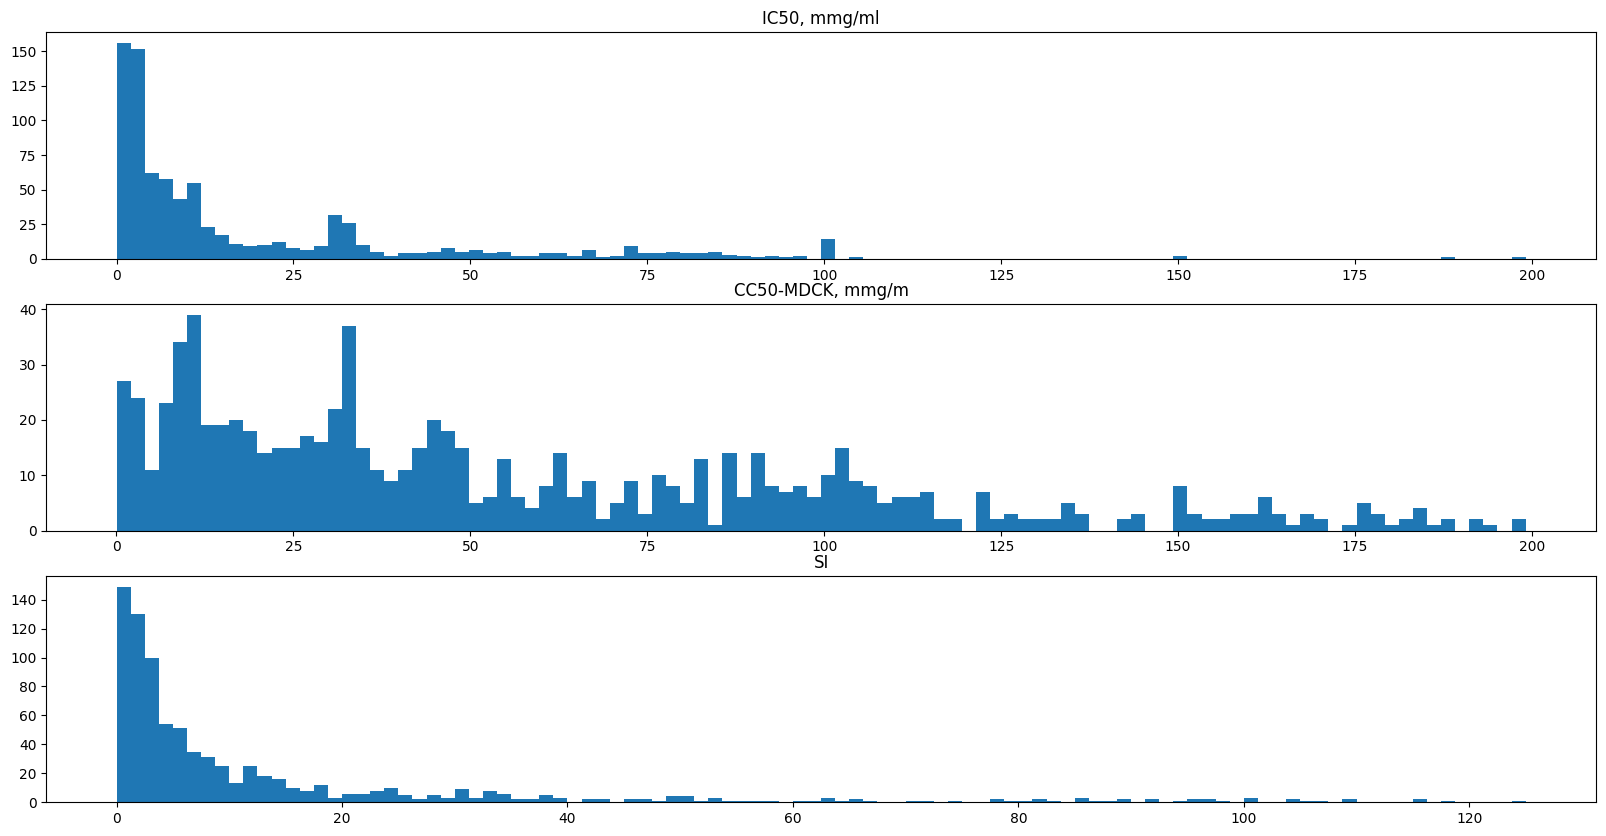

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,10))
#ax1.title("IC50, mmg/ml")
ax1.hist(x=df_1400["IC50, mmg/ml"], bins=100)
ax1.set_title("IC50, mmg/ml")
ax2.set_title("CC50-MDCK, mmg/m")
ax2.hist(x=df_1400["CC50-MDCK, mmg/ml"], bins=100)
ax3.set_title("SI")
ax3.hist(x=df_1400["SI"], bins=100)
plt.ticklabel_format(style = 'plain')

In [ ]:
Данные после преобразования, хоть и остались с явно выраженной правосторонней асимметрией, но не представляют из себя один большой выброс
Посмотрим базовую статистику по df_1400

In [12]:
print(f"Среднее значение целевого признака: {df_1400['SI'].mean()}")
print(f"Медианное значение целевого признака: {df_1400['SI'].median()}")
print(f"Стандартное отклонение целевого признака: {df_1400['SI'].std()}")

Среднее значение целевого признака: 13.330150620524094
Медианное значение целевого признака: 4.5
Стандартное отклонение целевого признака: 21.722400878304402


In [13]:
df_1400 = df_1400.reset_index(drop=True)

In [14]:
df_1400.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    835 non-null    object 
 1   IC50, mmg/ml             835 non-null    float64
 2   CC50-MDCK, mmg/ml        835 non-null    float64
 3   SI                       835 non-null    float64
 4   Molecular weight         835 non-null    float64
 5   Hydrogen bond acceptors  835 non-null    int64  
 6   Hydrogen bond donors     835 non-null    int64  
 7   Polar SA                 835 non-null    float64
 8   SMILES                   835 non-null    object 
 9   Pictures                 303 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 65.4+ KB


In [15]:
dict_of_descriptors = {}
for i in range(len(Descriptors._descList)):
    dict_of_descriptors[Descriptors._descList[i][0]] = Descriptors._descList[i][1]

In [16]:
def mol_dsc_calc(mols):
    return pd.DataFrame(
        {k: f(Chem.MolFromSmiles(m)) for k, f in dict_of_descriptors.items()}
        for m in mols
    )


# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
X = descriptors_transformer.transform(df_1400["SMILES"])
X.sample(3)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
704,12.998908,12.998908,0.114423,-0.394830,0.757971,349.369,333.241,349.133888,130,0,...,0,0,0,0,0,0,0,0,0,0
192,6.295764,6.295764,0.405432,0.405432,0.781154,267.413,238.181,267.219829,110,0,...,0,0,0,0,0,0,0,0,0,0
507,15.456461,15.456461,0.022140,-1.244149,0.786511,352.446,323.214,352.204988,140,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
X.columns

NameError: name 'X' is not defined

In [17]:
X["Molecular weight"] = df_1400["Molecular weight"]
X["Hydrogen bond acceptors"] = df_1400["Hydrogen bond acceptors"]
X["Hydrogen bond donors"] = df_1400["Hydrogen bond donors"]
X["Polar SA"] = df_1400["Polar SA"]
X["y"] = df_1400["SI"]

In [18]:
X = X.dropna().reset_index(drop=True)

# RandomForest

## Подготовка данных

Подготовка данных будет заключаться в разделении основных выборок на тренировочную и тестовую. Помимо этого, предлагается провести стандартизацию признаков

### Разделение выборок

In [ ]:
(X_train_forest_start,
 X_test_forest_start,
 y_train_forest_start,
 y_test_forest_start) = train_test_split(X.drop("y", axis=1),
                                         X["y"],
                                         test_size=0.25,
                                         random_state=RANDOM_STATE)

### Стандартизация признаков

In [ ]:
scaler = StandardScaler()
X_train_forest_start_scale = scaler.fit_transform(X_train_forest_start)
X_test_forest_start_scale = scaler.transform(X_test_forest_start)

### Обучение

Заранее выпишем гиперпараметры, по которым будем проводить кросс-валидацию

In [ ]:
params_forest = {
    "n_estimators": [25, 50, 75, 100, 125, 150, 175, 200],
    "max_depth": [i for i in range(1, 11)],
    "criterion": [
        "squared_error",
        "absolute_error",
        "friedman_mse",
        "poisson",
    ],  # Критерий, по которому происходит разбиение вершины дерева
}

#### Обучение на исходной выборке

Обучим случайный лес на исходной выборке

In [ ]:
model_random_forest_start = RandomForestRegressor(random_state=RANDOM_STATE)

model_forest_start = GridSearchCV(
    estimator=model_random_forest_start,
    param_grid=params_forest,
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

s = time.time()
model_forest_start.fit(X_train_forest_start, y_train_forest_start)
e = time.time()
print("Случайный лес:")
print(f"Лучшие параметры: {model_forest_start.best_params_}")
print(f"Скорость обучения: {round(e-s,2)}")
print(f"RMSE для лучших параметров:", round(model_forest_start.best_score_ * (-1), 2))
s = time.time()
pred = model_forest_start.predict(X_train_forest_start)
e = time.time()
print(f"Скорость предсказания модели: {round(e-s,2)}")

Случайный лес:
Лучшие параметры: {'criterion': 'poisson', 'max_depth': 5, 'n_estimators': 200}
Скорость обучения: 799.4
RMSE для лучших параметров: 20.62
Скорость предсказания модели: 0.01


#### Обучение на стандартизированной выборке

In [ ]:
model_random_forest_scale = RandomForestRegressor(random_state=RANDOM_STATE)

model_forest_scale = GridSearchCV(
    estimator=model_random_forest_scale,
    param_grid=params_forest,
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

s = time.time()
model_forest_scale.fit(X_train_forest_start_scale, y_train_forest_start)
e = time.time()
print("Случайный лес:")
print(f"Лучшие параметры: {model_forest_scale.best_params_}")
print(f"Скорость обучения: {round(e-s,2)}")
print(f"RMSE для лучших параметров:", round(model_forest_scale.best_score_ * (-1), 2))
s = time.time()
pred_scale = model_forest_scale.predict(X_train_forest_start_scale)
e = time.time()
print(f"Скорость предсказания модели: {round(e-s,2)}")

Случайный лес:
Лучшие параметры: {'criterion': 'poisson', 'max_depth': 4, 'n_estimators': 200}
Скорость обучения: 794.57
RMSE для лучших параметров: 20.58
Скорость предсказания модели: 0.01


Как видно, результаты при случайном лесе практически идентичны для стандартизированной выборке и исходной.

# LGBoost

## Подготовка данных

### Разделение выборок

In [ ]:
(X_train_lgb_start,
 X_test_lgb_start,
 y_train_lgb_start,
 y_test_lgb_start) = train_test_split(X.drop("y", axis=1),
                                         X["y"],
                                         test_size=0.25,
                                         random_state=RANDOM_STATE)

### Стандартизация признаков

In [ ]:
scaler = StandardScaler()
X_train_lgb_start_scale = scaler.fit_transform(X_train_lgb_start)
X_test_lgb_start_scale = scaler.transform(X_test_lgb_start)

### Обучение

Заранее выпишем гиперпараметры, по которым будем проводить кросс-валидацию

In [ ]:
params_lgb = {
    "learning_rate": [0.0003, 0.003, 0.03, 0.01, 0.1, 1],
    "n_estimators": range(50, 251, 50),
    "num_leaves": range(31,52,5)}

#### Обучение на исходной выборке

In [ ]:
lgbst_start = lgb.LGBMRegressor(objective="regression", random_state=RANDOM_STATE)

model_lgb_start = GridSearchCV(
                               estimator=lgbst_start,
                               param_grid=params_lgb,
                               cv=3,
                               n_jobs=-1,
                               scoring="neg_root_mean_squared_error")
s = time.time()
model_lgb_start.fit(X_train_lgb_start, y_train_lgb_start)
e = time.time()
print("LGBMRegressor:")
print(f"Лучшие параметры: {model_lgb_start.best_params_}")
print(f"Скорость обучения: {round(e-s,2)}")
print(f"RMSE для лучших параметров:", round(model_lgb_start.best_score_ * (-1), 0))
s = time.time()
pred_lgb = model_lgb_start.predict(X_train_lgb_start)
e = time.time()
print(f"Скорость предсказания модели: {round(e-s,2)}")

LGBMRegressor:
Лучшие параметры: {'learning_rate': 0.01, 'n_estimators': 150, 'num_leaves': 31}
Скорость обучения: 25.35
RMSE для лучших параметров: 20.0
Скорость предсказания модели: 0.0


#### Обучение на стандартизированной выборке

In [ ]:
lgbst_scale = lgb.LGBMRegressor(objective="regression", random_state=RANDOM_STATE)

model_lgb_scale = GridSearchCV(
                               estimator=lgbst_scale,
                               param_grid=params_lgb,
                               cv=3,
                               n_jobs=-1,
                               scoring="neg_root_mean_squared_error")
s = time.time()
model_lgb_scale.fit(X_train_lgb_start_scale, y_train_lgb_start)
e = time.time()
print("LGBMRegressor:")
print(f"Лучшие параметры: {model_lgb_scale.best_params_}")
print(f"Скорость обучения: {round(e-s,2)}")
print(f"RMSE для лучших параметров:", round(model_lgb_scale.best_score_ * (-1), 0))
s = time.time()
pred_lgb_scale = model_lgb_scale.predict(X_train_lgb_start_scale)
e = time.time()
print(f"Скорость предсказания модели: {round(e-s,2)}")

LGBMRegressor:
Лучшие параметры: {'learning_rate': 0.01, 'n_estimators': 150, 'num_leaves': 31}
Скорость обучения: 29.92
RMSE для лучших параметров: 20.0
Скорость предсказания модели: 0.0


Как видно, результаты при использовании LGboost практически идентичны для стандартизированной выборке и исходной.

# XGBoost


## Подготовка данных

### Разделение выборок

In [ ]:
(X_train_xgb_start,
 X_test_xgb_start,
 y_train_xgb_start,
 y_test_xgb_start) = train_test_split(X.drop("y", axis=1),
                                         X["y"],
                                         test_size=0.25,
                                         random_state=RANDOM_STATE)

### Стандартизация признаков

In [ ]:
scaler = StandardScaler()
X_train_xgb_scale = scaler.fit_transform(X_train_xgb_start)
X_test_xgb_scale = scaler.transform(X_test_xgb_start)

### Обучение

In [ ]:
params_xgb = {
            'max_depth': range(5,36,5),
            'alpha': [10],
            "learning_rate": [0.0003, 0.003, 0.03, 0.01, 0.1, 1],
            "n_estimators": range(50, 251, 50)
        }

#### Обучение на исходной выборке

In [ ]:
xgb_start = XGBRegressor()

model_xgb_start = GridSearchCV(
                               estimator=xgb_start,
                               param_grid=params_xgb,
                               cv=3,
                               n_jobs=-1,
                               scoring="neg_root_mean_squared_error")
s = time.time()
model_xgb_start.fit(X_train_xgb_start, y_train_xgb_start)
e = time.time()
print("LGBMRegressor:")
print(f"Лучшие параметры: {model_xgb_start.best_params_}")
print(f"Скорость обучения: {round(e-s,2)}")
print(f"RMSE для лучших параметров:", round(model_xgb_start.best_score_ * (-1), 0))
s = time.time()
pred_xgb = model_xgb_start.predict(X_train_xgb_start)
e = time.time()
print(f"Скорость предсказания модели: {round(e-s,2)}")

LGBMRegressor:
Лучшие параметры: {'alpha': 10, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Скорость обучения: 314.68
RMSE для лучших параметров: 21.0
Скорость предсказания модели: 0.01


#### Обучение на стандартизированной выборке

In [ ]:
xgb_scale = XGBRegressor()

model_xgb_scale = GridSearchCV(
                               estimator=xgb_scale,
                               param_grid=params_xgb,
                               cv=3,
                               n_jobs=-1,
                               scoring="neg_root_mean_squared_error")
s = time.time()
model_xgb_scale.fit(X_train_xgb_scale, y_train_xgb_start)
e = time.time()
print("LGBMRegressor:")
print(f"Лучшие параметры: {model_xgb_scale.best_params_}")
print(f"Скорость обучения: {round(e-s,2)}")
print(f"RMSE для лучших параметров:", round(model_xgb_scale.best_score_ * (-1), 0))
s = time.time()
pred_xgb_scale = model_xgb_scale.predict(X_train_xgb_scale)
e = time.time()
print(f"Скорость предсказания модели: {round(e-s,2)}")

LGBMRegressor:
Лучшие параметры: {'alpha': 10, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Скорость обучения: 304.55
RMSE для лучших параметров: 21.0
Скорость предсказания модели: 0.0


Как видно, результаты при использовании XGboost практически идентичны для стандартизированной выборке и исходной.

# Catboost

## Подготовка данных

### Разделение выборок

In [19]:
(X_train_cat_start,
 X_test_cat_start,
 y_train_cat_start,
 y_test_cat_start) = train_test_split(X.drop("y", axis=1),
                                         X["y"],
                                         test_size=0.25,
                                         random_state=RANDOM_STATE)

### Стандартизация признаков

In [20]:
scaler = StandardScaler()
X_train_cat_scale = scaler.fit_transform(X_train_cat_start)
X_test_cat_scale = scaler.transform(X_test_cat_start)

### Обучение

In [21]:
cb_params = {"learning_rate": [0.003, 0.03, 0.01, 0.1, 1],
             'max_depth': range(5,36,5),
             "n_estimators": range(50, 251, 50)}

#### Обучение на исходной выборке

In [23]:
cat_start = CatBoostRegressor()

model_cat_start = RandomizedSearchCV(
                               estimator=cat_start,
                               param_distributions=cb_params,
                               cv=3,
                               n_jobs=-1,
                               scoring="neg_root_mean_squared_error")
s = time.time()
model_cat_start.fit(X_train_cat_start, y_train_cat_start)
e = time.time()
print("LGBMRegressor:")
print(f"Лучшие параметры: {model_cat_start.best_params_}")
print(f"Скорость обучения: {round(e-s,2)}")
print(f"RMSE для лучших параметров:", round(model_cat_start.best_score_ * (-1), 0))
s = time.time()
model_cat_start = model_cat_start.predict(X_train_cat_start)
e = time.time()
print(f"Скорость предсказания модели: {round(e-s,2)}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2303, in _fit
    train_para

0:	learn: 21.4435993	total: 447ms	remaining: 1m 28s
1:	learn: 21.4279193	total: 834ms	remaining: 1m 22s
2:	learn: 21.4132720	total: 1.22s	remaining: 1m 19s
3:	learn: 21.3990747	total: 1.61s	remaining: 1m 18s
4:	learn: 21.3836215	total: 2s	remaining: 1m 17s
5:	learn: 21.3725089	total: 2.39s	remaining: 1m 17s
6:	learn: 21.3607635	total: 2.64s	remaining: 1m 12s
7:	learn: 21.3474267	total: 2.83s	remaining: 1m 7s
8:	learn: 21.3359623	total: 3.02s	remaining: 1m 4s
9:	learn: 21.3227212	total: 3.22s	remaining: 1m 1s
10:	learn: 21.3098785	total: 3.41s	remaining: 58.6s
11:	learn: 21.2969663	total: 3.62s	remaining: 56.7s
12:	learn: 21.2802029	total: 3.81s	remaining: 54.8s
13:	learn: 21.2645824	total: 4.01s	remaining: 53.3s
14:	learn: 21.2529543	total: 4.21s	remaining: 51.9s
15:	learn: 21.2412117	total: 4.4s	remaining: 50.6s
16:	learn: 21.2272094	total: 4.59s	remaining: 49.5s
17:	learn: 21.2144878	total: 4.8s	remaining: 48.6s
18:	learn: 21.2020289	total: 5s	remaining: 47.6s
19:	learn: 21.1878426	t

#### Обучение на стандартизированной выборке

In [24]:
cat_scale = CatBoostRegressor()

model_cat_scale = RandomizedSearchCV(
                               estimator=cat_scale,
                               param_distributions=cb_params,
                               cv=3,
                               n_jobs=-1,
                               scoring="neg_root_mean_squared_error")
s = time.time()
model_cat_scale.fit(X_train_cat_scale, y_train_cat_start)
e = time.time()
print("LGBMRegressor:")
print(f"Лучшие параметры: {model_cat_scale.best_params_}")
print(f"Скорость обучения: {round(e-s,2)}")
print(f"RMSE для лучших параметров:", round(model_cat_scale.best_score_ * (-1), 0))
s = time.time()
model_cat_start = model_cat_scale.predict(X_train_cat_scale)
e = time.time()
print(f"Скорость предсказания модели: {round(e-s,2)}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2303, in _fit
    train_para

0:	learn: 21.4462672	total: 14.1ms	remaining: 3.51s
1:	learn: 21.4376168	total: 27.1ms	remaining: 3.36s
2:	learn: 21.4262107	total: 39.6ms	remaining: 3.26s
3:	learn: 21.4183576	total: 51.3ms	remaining: 3.15s
4:	learn: 21.4107236	total: 63.3ms	remaining: 3.1s
5:	learn: 21.4026147	total: 75.1ms	remaining: 3.06s
6:	learn: 21.3949586	total: 87.2ms	remaining: 3.03s
7:	learn: 21.3861576	total: 99.2ms	remaining: 3s
8:	learn: 21.3743416	total: 111ms	remaining: 2.97s
9:	learn: 21.3672623	total: 123ms	remaining: 2.96s
10:	learn: 21.3605598	total: 135ms	remaining: 2.94s
11:	learn: 21.3523583	total: 147ms	remaining: 2.91s
12:	learn: 21.3450913	total: 159ms	remaining: 2.89s
13:	learn: 21.3373518	total: 171ms	remaining: 2.88s
14:	learn: 21.3300222	total: 188ms	remaining: 2.95s
15:	learn: 21.3208835	total: 200ms	remaining: 2.92s
16:	learn: 21.3126939	total: 211ms	remaining: 2.9s
17:	learn: 21.3037370	total: 226ms	remaining: 2.91s
18:	learn: 21.2923391	total: 238ms	remaining: 2.89s
19:	learn: 21.28399

Как видно, результаты при использовании Catboost практически идентичны для стандартизированной выборке и исходной.

In [ ]:
info = {}
from rdkit.Chem import AllChem, rdFingerprintGenerator
X_n=[]
fpgen = AllChem.GetMorganGenerator(radius=2)
for i in df_1400["SMILES"].to_numpy():
    mol = Chem.MolFromSmiles(i)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=10, nBits = 1024, bitInfo=info)
    vector = np.array(fp)
    X_n.append(vector)

X_new = np.array(X_n)
len(X_new)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(result_X, y, test_size=.25, random_state=12345)

In [ ]:
import catboost
from sklearn.metrics import mean_squared_error, r2_score

boosting_model_pad = catboost.CatBoostRegressor(n_estimators=1,max_depth=16, logging_level="Verbose",loss_function="RMSE",learning_rate = 1)
boosting_model_pad.fit(X_train, y_train)

preds_test=boosting_model_pad.predict(X_test)
preds_train=boosting_model_pad.predict(X_train)
#mean_absolute_error(preds_train, y_test)
#print(preds_train[10],y_test[10])
RMSE_test = (mean_squared_error(y_test,preds_test))**(0.5)
RMSE_train = (mean_squared_error(y_train, preds_train))**(0.5)
R2_test = r2_score(y_test,preds_test)
R2_train = r2_score(y_train, preds_train)

print(
    'RMSE TEST: ', RMSE_test, '\n',
    'RMSE TRAIN: ', RMSE_train, '\n',
    'R2_TEST: ', R2_test, '\n',
    'R2_TRAIN: ', R2_train)

# RNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop("y", axis=1), X["y"], test_size=0.25, random_state=RANDOM_STATE
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.20, random_state=RANDOM_STATE
)

In [ ]:
X_train_nn = torch.from_numpy(X_train.to_numpy()).to(torch.float32)  # .to(device)
X_valid_nn = torch.from_numpy(X_valid.to_numpy()).to(torch.float32)  # .to(device)
X_test_nn = torch.from_numpy(X_test.to_numpy()).to(torch.float32)  # .to(device)

y_train_nn = torch.from_numpy(y_train.to_numpy()).to(torch.float32)  # .to(device)
y_valid_nn = torch.from_numpy(y_valid.to_numpy()).to(torch.float32)  # .to(device)
y_test_nn = torch.from_numpy(y_test.to_numpy()).to(torch.float32)  # .to(device)

In [ ]:
scaler = StandardScaler()

X_train_nn_scaler = (
    torch.from_numpy(scaler.fit_transform(X_train_nn)).to(torch.float32).to(device)
)
X_valid_nn_scaler = (
    torch.from_numpy(scaler.transform(X_valid_nn)).to(torch.float32).to(device)
)
X_test_nn_scaler = (
    torch.from_numpy(scaler.transform(X_test_nn)).to(torch.float32).to(device)
)

scaler = StandardScaler()
y_train_nn_scaler = (
    torch.from_numpy(scaler.fit_transform(y_train_nn.reshape(-1, 1)))
    .to(torch.float32)
    .to(device)
)
y_valid_nn_scaler = (
    torch.from_numpy(scaler.transform(y_valid_nn.reshape(-1, 1)))
    .to(torch.float32)
    .to(device)
)
y_test_nn_nn_scaler = (
    torch.from_numpy(scaler.transform(y_test_nn.reshape(-1, 1)))
    .to(torch.float32)
    .to(device)
)

In [ ]:
X_train_nn = X_train_nn.to(device)
X_valid_nn = X_valid_nn.to(device)
X_test_nn = X_test_nn.to(device)

y_train_nn = y_train_nn.to(device)
y_valid_nn = y_valid_nn.to(device)
y_test_nn = y_test_nn.to(device)

In [ ]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        # self.lstm = nn.GRU(input_size=dimensions, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False, dropout  = 0.2)
        self.lstm = nn.RNN(
            input_size=dimensions,
            hidden_size=lstm_size,
            num_layers=1,
            batch_first=True,
            bidirectional=False,
            dropout=0.2,
        )
        self.fc1 = nn.Linear(lstm_size, hidden_size)  # Output layer
        self.activation = nn.ReLU()  # Non-Linear ReLU Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # Output layer
        self.activation2 = nn.ReLU()  # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size // 2, out_size)  # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):  # Forward pass: stacking each layer together
        # out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(
            x
        )  # GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n)  # Dropout
        out = self.fc1(out)  # Pass into the hidden layer
        out = self.activation(out)  # Use ReLU on hidden activation
        out = self.fc2(out)  # Pass into the hidden layer
        out = self.activation2(out)  # Use ReLU on hidden activation
        out = self.dropout(out)  # dropout
        out = self.fc_out(out)  # Use a linear layer for the output
        return out

# ПАРАМЕТРЫ НЕЙРОНКИ

In [ ]:
################################################################################
epochs = 750
dims = X_valid_nn.shape[1]
lstm_size = 64  # The size of the LSTM layer
hidden_size = 50  # The size of the hidden non-linear layer
dropout_rate = 0.25  # The dropout rate
output_size = 1  # This is just a single task, so this will be one
batch_size = 50  # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer
################################################################################

In [ ]:
model = Net(dims, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

In [ ]:
# pred = model.forward(X_train_nn_scaler[10:11])
# pred

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=50,
    verbose=True,
    threshold=0.0001,
    threshold_mode="rel",
    cooldown=0,
    min_lr=1e-6,
    eps=1e-08,
)

In [ ]:
import torch.utils.data as data_utils

# train = data_utils.TensorDataset(X_train_nn, y_train_nn)
# train = data_utils.TensorDataset(X_train_nn_scaler, y_train_nn)
train = data_utils.TensorDataset(X_train_nn_scaler, y_train_nn)

train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

In [ ]:
model.train()  # Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for features, targets in train_loader:
        # Push numpy to CUDA tensors
        features = torch.tensor(features, device=device).float()
        # print(features)
        targets = torch.tensor(targets, device=device).float()
        targets = torch.nan_to_num(targets, nan=torch.nanmean(targets))
        # print(targets)
        # break
        # Training pass
        optimizer.zero_grad()  # Initialize the gradients, which will be recorded during the forward pass

        output = model(features)  # Forward pass of the mini-batch
        RMSE_loss = torch.sqrt(criterion(output, targets))
        RMSE_loss.backward()
        # loss = criterion(output, targets) #Computing the loss # Изначальный лосс – MSE
        # loss.backward() # calculate the backward pass # Изначальный лосс – MSE
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()  # Optimize the weights

        # running_loss += loss.item()
        running_loss += RMSE_loss.item()
    else:
        model.eval()
        # validation_loss = torch.mean(( y_valid_nn - model(X_valid_nn) )**2).item() # Изначальный лосс – MSE
        # validation_loss = torch.sqrt(torch.mean(( y_valid_nn - model(X_valid_nn) )**2)).item()
        validation_loss = torch.sqrt(
            torch.mean((y_valid_nn - model(X_valid_nn_scaler)) ** 2)
        ).item()

        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e + 1) % 5 == 0:
            print(
                "Epoch %i, Training loss: %0.2F Validation loss: %0.2F"
                % (e + 1, train_loss, validation_loss)
            )

In [ ]:
f = plt.figure(figsize=(15, 5))
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
# plt.yscale('log')
plt.legend()